<a href="https://colab.research.google.com/github/AI4Finance-Foundation/FinRL-Tutorials/blob/master/1-Introduction/Stock_NeurIPS2018_SB3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep Reinforcement Learning for Stock Trading from Scratch: Multiple Stock Trading

* **Pytorch Version** 



# Content

* [1. Task Description](#0)
* [2. Install Python packages](#1)
    * [2.1. Install Packages](#1.1)    
    * [2.2. A List of Python Packages](#1.2)
    * [2.3. Import Packages](#1.3)
    * [2.4. Create Folders](#1.4)
* [3. Download and Preprocess Data](#2)
* [4. Preprocess Data](#3)        
    * [4.1. Technical Indicators](#3.1)
    * [4.2. Perform Feature Engineering](#3.2)
* [5. Build Market Environment in OpenAI Gym-style](#4)  
    * [5.1. Data Split](#4.1)  
    * [5.3. Environment for Training](#4.2)    
* [6. Train DRL Agents](#5)
* [7. Backtesting Performance](#6)  
    * [7.1. BackTestStats](#6.1)
    * [7.2. BackTestPlot](#6.2)   
  

<a id='0'></a>
# Part 1. Task Discription

We train a DRL agent for stock trading. This task is modeled as a Markov Decision Process (MDP), and the objective function is maximizing (expected) cumulative return.

We specify the state-action-reward as follows:

* **State s**: The state space represents an agent's perception of the market environment. Just like a human trader analyzing various information, here our agent passively observes many features and learns by interacting with the market environment (usually by replaying historical data).

* **Action a**: The action space includes allowed actions that an agent can take at each state. For example, a ∈ {−1, 0, 1}, where −1, 0, 1 represent
selling, holding, and buying. When an action operates multiple shares, a ∈{−k, ..., −1, 0, 1, ..., k}, e.g.. "Buy
10 shares of AAPL" or "Sell 10 shares of AAPL" are 10 or −10, respectively

* **Reward function r(s, a, s′)**: Reward is an incentive for an agent to learn a better policy. For example, it can be the change of the portfolio value when taking a at state s and arriving at new state s',  i.e., r(s, a, s′) = v′ − v, where v′ and v represent the portfolio values at state s′ and s, respectively


**Market environment**: 30 consituent stocks of Dow Jones Industrial Average (DJIA) index. Accessed at the starting date of the testing period.


The data for this case study is obtained from Yahoo Finance API. The data contains Open-High-Low-Close price and volume.


<a id='1'></a>
# Part 2. Install Python Packages

<a id='1.1'></a>
## 2.1. Install packages



<a id='1.2'></a>
## 2.2. A list of Python packages 
* Yahoo Finance API
* pandas
* numpy
* matplotlib
* stockstats
* OpenAI gym
* stable-baselines
* tensorflow
* pyfolio

<a id='1.3'></a>
## 2.3. Import Packages

In [2]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
# matplotlib.use('Agg')
import datetime

%matplotlib inline

from finrl.meta.preprocessor.yahoodownloader import YahooDownloader
from finrl.meta.preprocessor.preprocessors import FeatureEngineer, data_split
from finrl.meta.env_stock_trading.env_stocktrading import StockTradingEnv
from finrl.agents.stablebaselines3.models import DRLAgent
from stable_baselines3.common.logger import configure
from finrl.meta.data_processor import DataProcessor
from finrl.meta.data_processors.processor_yahoofinance import YahooFinanceProcessor
from finrl.plot import backtest_stats, backtest_plot, get_daily_return, get_baseline
from pprint import pprint
from finrl.meta.data_processors.processor_alpaca import AlpacaProcessor
from finrl.meta.data_processor import DataProcessor

import sys
sys.path.append("../FinRL")

import itertools

/home/mike/miniconda3/envs/finrl/lib/python3.11/site-packages/pyfolio/pos.py:26: UserWarning: Module "zipline.assets" not found; mutltipliers will not be applied to position notionals.
  warnings.warn(


<a id='1.4'></a>
## 2.4. Create Folders

In [3]:
from finrl import config
from finrl import config_tickers
import os
from finrl.main import check_and_make_directories
from finrl.config import (
    DATA_SAVE_DIR,
    TRAINED_MODEL_DIR,
    TENSORBOARD_LOG_DIR,
    RESULTS_DIR,
    INDICATORS,
    TRAIN_START_DATE,
    TRAIN_END_DATE,
    TEST_START_DATE,
    TEST_END_DATE,
    TRADE_START_DATE,
    TRADE_END_DATE,
)
check_and_make_directories([DATA_SAVE_DIR, TRAINED_MODEL_DIR, TENSORBOARD_LOG_DIR, RESULTS_DIR])



<a id='2'></a>
# Part 3. Download Data
Yahoo Finance provides stock data, financial news, financial reports, etc. Yahoo Finance is free.
* FinRL uses a class **YahooDownloader** in FinRL-Meta to fetch data via Yahoo Finance API
* Call Limit: Using the Public API (without authentication), you are limited to 2,000 requests per hour per IP (or up to a total of 48,000 requests a day).



-----
class YahooDownloader:
    Retrieving daily stock data from
    Yahoo Finance API

    Attributes
    ----------
        start_date : str
            start date of the data (modified from config.py)
        end_date : str
            end date of the data (modified from config.py)
        ticker_list : list
            a list of stock tickers (modified from config.py)

    Methods
    -------
    fetch_data()


In [4]:
TRAIN_START_DATE = '2025-01-01'
TRAIN_END_DATE = '2025-01-24'
TRADE_START_DATE = '2025-01-25'
TRADE_END_DATE = '2025-01-29'

In [5]:
#alpaca = AlpacaProcessor('PKB2PY7303VGIKFLW3O8', 'qa2nftQMSEIlFN4ShWSS2BCDCD5tlR10FIGyJNhw')
symbols = ['AMZN','NVDA','MSFT','ORCL','GOOGL','META','TSLA']



INDICATORS = [
    "macd",
    "boll_ub",
    "boll_lb",
    "rsi_30",
    "cci_30",
    "dx_30",
    "close_30_sma",
    "close_60_sma",
]

alpaca = AlpacaProcessor(API_KEY='PKB2PY7303VGIKFLW3O8', API_SECRET='qa2nftQMSEIlFN4ShWSS2BCDCD5tlR10FIGyJNhw')
df = alpaca.download_data(symbols, TRAIN_START_DATE, TRADE_END_DATE, '1Min')
processed = alpaca.clean_data(df)
processed = alpaca.add_technical_indicator(processed, tech_indicator_list=INDICATORS)
processed = alpaca.add_vix(processed)
processed = alpaca.add_turbulence(processed)
processed = processed.ffill().bfill()
processed['date'] = processed['timestamp']

Data cleaning started
align start and end dates
produce full timestamp index
Start processing tickers
ticker list complete
Start concat and rename
Data clean finished!
Started adding Indicators
Running Loop
Restore Timestamps
Finished adding Indicators
Data cleaning started
align start and end dates
produce full timestamp index
Start processing tickers
ticker list complete
Start concat and rename
Data clean finished!


# Part 4: Preprocess Data
We need to check for missing data and do feature engineering to convert the data point into a state.
* **Adding technical indicators**. In practical trading, various information needs to be taken into account, such as historical prices, current holding shares, technical indicators, etc. Here, we demonstrate two trend-following technical indicators: MACD and RSI.
* **Adding turbulence index**. Risk-aversion reflects whether an investor prefers to protect the capital. It also influences one's trading strategy when facing different market volatility level. To control the risk in a worst-case scenario, such as financial crisis of 2007–2008, FinRL employs the turbulence index that measures extreme fluctuation of asset price.

<a id='4'></a>
# Part 5. Build A Market Environment in OpenAI Gym-style
The training process involves observing stock price change, taking an action and reward's calculation. By interacting with the market environment, the agent will eventually derive a trading strategy that may maximize (expected) rewards.

Our market environment, based on OpenAI Gym, simulates stock markets with historical market data.

## Data Split
We split the data into training set and testing set as follows:

Training data period: 2009-01-01 to 2020-07-01

Trading data period: 2020-07-01 to 2021-10-31


In [6]:
processed.count()

timestamp       49140
open            49140
high            49140
low             49140
close           49140
volume          49140
tic             49140
macd            49140
boll_ub         49140
boll_lb         49140
rsi_30          49140
cci_30          49140
dx_30           49140
close_30_sma    49140
close_60_sma    49140
VIXY            49140
turbulence      49140
date            49140
dtype: int64

In [7]:
train = data_split(processed, TRAIN_START_DATE,TRAIN_END_DATE)
trade = data_split(processed, TRADE_START_DATE,TRADE_END_DATE)
train_length = len(train)
trade_length = len(trade)
print(train_length)
print(trade_length)

38220
5460


In [8]:
train.describe()

,open,high,low,close,volume,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,VIXY,turbulence
count,38220.000000,38220.000000,38220.000000,38220.000000,3.822000e+04,38220.000000,38220.000000,38220.000000,38220.000000,38220.000000,38220.000000,38220.000000,38220.000000,38220.000000,38220.000000
mean,309.820373,310.016489,309.618109,309.818516,1.191878e+05,0.024969,310.749885,308.788502,50.622382,4.068199,23.557399,309.765744,309.713006,44.384686,16.288057
std,162.985485,163.090443,162.877457,162.984984,2.574232e+05,0.491304,163.485559,162.433197,8.822136,116.715643,17.709752,162.954443,162.924927,2.420328,184.480966
min,129.880000,130.340000,129.510000,129.880000,8.770000e+02,-4.544310,130.776582,127.187888,0.000000,-966.554470,0.000180,130.557240,130.686580,40.990000,0.000000
25%,166.420000,166.486675,166.340000,166.413750,1.769075e+04,-0.109964,166.801480,166.108688,45.329224,-83.814657,9.412988,166.373472,166.360025,42.530000,1.709218
50%,223.080000,223.180000,222.980000,223.080000,3.661650e+04,0.010163,223.491770,222.550527,50.590652,7.606642,19.839136,223.088257,223.047430,43.870000,3.407196
75%,422.962500,423.181250,422.742500,422.955500,1.181505e+05,0.141844,423.968930,421.718002,55.975409,90.418002,34.036160,422.729328,422.745749,46.321250,7.103484
max,636.196300,636.600000,636.000000,636.480000,1.725661e+07,6.205895,636.416185,632.166628,100.000000,1000.000000,100.000000,633.319313,632.732717,50.570000,7501.898150


In [9]:
stock_dimension = len(train.tic.unique())
state_space = 1 + 2*stock_dimension + len(INDICATORS)*stock_dimension
print(f"Stock Dimension: {stock_dimension}, State Space: {state_space}")

Stock Dimension: 7, State Space: 71


In [10]:
buy_cost_list = sell_cost_list = [0.001] * stock_dimension
num_stock_shares = [0] * stock_dimension

env_kwargs = {
    "hmax": 100,
    "initial_amount": 1000000,
    "num_stock_shares": num_stock_shares,
    "buy_cost_pct": buy_cost_list,
    "sell_cost_pct": sell_cost_list,
    "state_space": state_space,
    "stock_dim": stock_dimension,
    "tech_indicator_list": INDICATORS,
    "action_space": stock_dimension,
    "reward_scaling": 1e-4
}


e_train_gym = StockTradingEnv(df = train, **env_kwargs)


## Environment for Training



In [11]:
env_train, _ = e_train_gym.get_sb_env()
print(type(env_train))

<class 'stable_baselines3.common.vec_env.dummy_vec_env.DummyVecEnv'>


<a id='5'></a>
# Part 6: Train DRL Agents
* The DRL algorithms are from **Stable Baselines 3**. Users are also encouraged to try **ElegantRL** and **Ray RLlib**.
* FinRL includes fine-tuned standard DRL algorithms, such as DQN, DDPG, Multi-Agent DDPG, PPO, SAC, A2C and TD3. We also allow users to
design their own DRL algorithms by adapting these DRL algorithms.

In [12]:
agent = DRLAgent(env = env_train)

if_using_a2c = True
if_using_ddpg = True
if_using_ppo = True
if_using_td3 = True
if_using_sac = True


### Agent Training: 5 algorithms (A2C, DDPG, PPO, TD3, SAC)


### Agent 1: A2C


In [13]:
agent = DRLAgent(env = env_train)
model_a2c = agent.get_model("a2c")

if if_using_a2c:
  # set up logger
  tmp_path = RESULTS_DIR + '/a2c'
  new_logger_a2c = configure(tmp_path, ["stdout", "csv", "tensorboard"])
  # Set new logger
  model_a2c.set_logger(new_logger_a2c)

trained_a2c = agent.train_model(model=model_a2c, 
                             tb_log_name='a2c',
                             total_timesteps=50000) if if_using_a2c else None

{'n_steps': 5, 'ent_coef': 0.01, 'learning_rate': 0.0007}
Using cuda device
Logging to results/a2c


/home/mike/miniconda3/envs/finrl/lib/python3.11/site-packages/stable_baselines3/common/on_policy_algorithm.py:150: UserWarning: You are trying to run A2C on the GPU, but it is primarily intended to run on the CPU when not using a CNN policy (you are using ActorCriticPolicy which should be a MlpPolicy). See https://github.com/DLR-RM/stable-baselines3/issues/1245 for more info. You can pass `device='cpu'` or `export CUDA_VISIBLE_DEVICES=` to force using the CPU.Note: The model will train, but the GPU utilization will be poor and the training might take longer than on CPU.
  warnings.warn(


---------------------------------------
| time/                 |             |
|    fps                | 243         |
|    iterations         | 100         |
|    time_elapsed       | 2           |
|    total_timesteps    | 500         |
| train/                |             |
|    entropy_loss       | -10         |
|    explained_variance | -2.22       |
|    learning_rate      | 0.0007      |
|    n_updates          | 99          |
|    policy_loss        | -2.07       |
|    reward             | 0.031297874 |
|    std                | 1.01        |
|    value_loss         | 0.0718      |
---------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 262       |
|    iterations         | 200       |
|    time_elapsed       | 3         |
|    total_timesteps    | 1000      |
| train/                |           |
|    entropy_loss       | -10.1     |
|    explained_variance | -0.444    |
|    learning_rate

### Agent 2: DDPG

In [14]:
agent = DRLAgent(env = env_train)
model_ddpg = agent.get_model("ddpg")

if if_using_ddpg:
  # set up logger
  tmp_path = RESULTS_DIR + '/ddpg'
  new_logger_ddpg = configure(tmp_path, ["stdout", "csv", "tensorboard"])
  # Set new logger
  model_ddpg.set_logger(new_logger_ddpg)
trained_ddpg = agent.train_model(model=model_ddpg, 
                             tb_log_name='ddpg',
                             total_timesteps=50000) if if_using_ddpg else None

{'batch_size': 128, 'buffer_size': 50000, 'learning_rate': 0.001}
Using cuda device
Logging to results/ddpg
---------------------------------
| time/              |          |
|    episodes        | 4        |
|    fps             | 154      |
|    time_elapsed    | 141      |
|    total_timesteps | 21840    |
| train/             |          |
|    actor_loss      | -8.5     |
|    critic_loss     | 0.004    |
|    learning_rate   | 0.001    |
|    n_updates       | 21739    |
|    reward          | 0.05772  |
---------------------------------
---------------------------------
| time/              |          |
|    episodes        | 8        |
|    fps             | 154      |
|    time_elapsed    | 283      |
|    total_timesteps | 43680    |
| train/             |          |
|    actor_loss      | -2.42    |
|    critic_loss     | 0.038    |
|    learning_rate   | 0.001    |
|    n_updates       | 43579    |
|    reward          | 0.05772  |
---------------------------------
day: 545

### Agent 3: PPO

In [15]:
agent = DRLAgent(env = env_train)
PPO_PARAMS = {
    "n_steps": 2048,
    "ent_coef": 0.01,
    "learning_rate": 0.00025,
    "batch_size": 128,
}
model_ppo = agent.get_model("ppo",model_kwargs = PPO_PARAMS)

if if_using_ppo:
  # set up logger
  tmp_path = RESULTS_DIR + '/ppo'
  new_logger_ppo = configure(tmp_path, ["stdout", "csv", "tensorboard"])
  # Set new logger
  model_ppo.set_logger(new_logger_ppo)
trained_ppo = agent.train_model(model=model_ppo, 
                             tb_log_name='ppo',
                             total_timesteps=50000) if if_using_ppo else None

{'n_steps': 2048, 'ent_coef': 0.01, 'learning_rate': 0.00025, 'batch_size': 128}
Using cuda device
Logging to results/ppo


/home/mike/miniconda3/envs/finrl/lib/python3.11/site-packages/stable_baselines3/common/on_policy_algorithm.py:150: UserWarning: You are trying to run PPO on the GPU, but it is primarily intended to run on the CPU when not using a CNN policy (you are using ActorCriticPolicy which should be a MlpPolicy). See https://github.com/DLR-RM/stable-baselines3/issues/1245 for more info. You can pass `device='cpu'` or `export CUDA_VISIBLE_DEVICES=` to force using the CPU.Note: The model will train, but the GPU utilization will be poor and the training might take longer than on CPU.
  warnings.warn(


------------------------------------
| time/              |             |
|    fps             | 347         |
|    iterations      | 1           |
|    time_elapsed    | 5           |
|    total_timesteps | 2048        |
| train/             |             |
|    reward          | -0.05747443 |
------------------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 332           |
|    iterations           | 2             |
|    time_elapsed         | 12            |
|    total_timesteps      | 4096          |
| train/                  |               |
|    approx_kl            | 0.009033721   |
|    clip_fraction        | 0.1           |
|    clip_range           | 0.2           |
|    entropy_loss         | -9.95         |
|    explained_variance   | -1.07         |
|    learning_rate        | 0.00025       |
|    loss                 | -0.0734       |
|    n_updates            | 10            |
|    po

### Agent 4: TD3

In [16]:
agent = DRLAgent(env = env_train)
TD3_PARAMS = {"batch_size": 100, 
              "buffer_size": 1000000, 
              "learning_rate": 0.001}

model_td3 = agent.get_model("td3",model_kwargs = TD3_PARAMS)

if if_using_td3:
  # set up logger
  tmp_path = RESULTS_DIR + '/td3'
  new_logger_td3 = configure(tmp_path, ["stdout", "csv", "tensorboard"])
  # Set new logger
  model_td3.set_logger(new_logger_td3)
trained_td3 = agent.train_model(model=model_td3, 
                             tb_log_name='td3',
                             total_timesteps=50000) if if_using_td3 else None

{'batch_size': 100, 'buffer_size': 1000000, 'learning_rate': 0.001}
Using cuda device
Logging to results/td3
---------------------------------
| time/              |          |
|    episodes        | 4        |
|    fps             | 165      |
|    time_elapsed    | 132      |
|    total_timesteps | 21840    |
| train/             |          |
|    actor_loss      | 85       |
|    critic_loss     | 2.04     |
|    learning_rate   | 0.001    |
|    n_updates       | 21739    |
|    reward          | 0.072759 |
---------------------------------
---------------------------------
| time/              |          |
|    episodes        | 8        |
|    fps             | 164      |
|    time_elapsed    | 265      |
|    total_timesteps | 43680    |
| train/             |          |
|    actor_loss      | 53.7     |
|    critic_loss     | 0.217    |
|    learning_rate   | 0.001    |
|    n_updates       | 43579    |
|    reward          | 0.072759 |
---------------------------------
day: 54

### Agent 5: SAC

In [17]:
agent = DRLAgent(env = env_train)
SAC_PARAMS = {
    "batch_size": 128,
    "buffer_size": 100000,
    "learning_rate": 0.0001,
    "learning_starts": 100,
    "ent_coef": "auto_0.1",
}

model_sac = agent.get_model("sac",model_kwargs = SAC_PARAMS)

if if_using_sac:
  # set up logger
  tmp_path = RESULTS_DIR + '/sac'
  new_logger_sac = configure(tmp_path, ["stdout", "csv", "tensorboard"])
  # Set new logger
  model_sac.set_logger(new_logger_sac)
trained_sac = agent.train_model(model=model_sac, 
                             tb_log_name='sac',
                             total_timesteps=50000) if if_using_sac else None

{'batch_size': 128, 'buffer_size': 100000, 'learning_rate': 0.0001, 'learning_starts': 100, 'ent_coef': 'auto_0.1'}
Using cuda device
Logging to results/sac
---------------------------------
| time/              |          |
|    episodes        | 4        |
|    fps             | 104      |
|    time_elapsed    | 208      |
|    total_timesteps | 21840    |
| train/             |          |
|    actor_loss      | 598      |
|    critic_loss     | 447      |
|    ent_coef        | 0.723    |
|    ent_coef_loss   | 3.07     |
|    learning_rate   | 0.0001   |
|    n_updates       | 21739    |
|    reward          | 0.096026 |
---------------------------------
---------------------------------
| time/              |          |
|    episodes        | 8        |
|    fps             | 103      |
|    time_elapsed    | 421      |
|    total_timesteps | 43680    |
| train/             |          |
|    actor_loss      | 224      |
|    critic_loss     | 11.6     |
|    ent_coef        | 0.22

## In-sample Performance

Assume that the initial capital is $1,000,000.

### Set turbulence threshold
Set the turbulence threshold to be greater than the maximum of insample turbulence data. If current turbulence index is greater than the threshold, then we assume that the current market is volatile

In [18]:
data_risk_indicator = processed[(processed.date<TRAIN_END_DATE) & (processed.date>=TRAIN_START_DATE)]
insample_risk_indicator = data_risk_indicator.drop_duplicates(subset=['date'])

In [20]:
insample_risk_indicator.VIXY.describe()

count    5460.000000
mean       44.384686
std         2.420518
min        40.990000
25%        42.530000
50%        43.870000
75%        46.321250
max        50.570000
Name: VIXY, dtype: float64

In [21]:
insample_risk_indicator.VIXY.quantile(0.996)

50.25

In [22]:
insample_risk_indicator.turbulence.describe()

count    5460.000000
mean       16.288057
std       184.495448
min         0.000000
25%         1.709218
50%         3.407196
75%         7.103484
max      7501.898150
Name: turbulence, dtype: float64

In [23]:
insample_risk_indicator.turbulence.quantile(0.996)

265.39213171580593

### Trading (Out-of-sample Performance)

We update periodically in order to take full advantage of the data, e.g., retrain quarterly, monthly or weekly. We also tune the parameters along the way, in this notebook we use the in-sample data from 2009-01 to 2020-07 to tune the parameters once, so there is some alpha decay here as the length of trade date extends. 

Numerous hyperparameters – e.g. the learning rate, the total number of samples to train on – influence the learning process and are usually determined by testing some variations.

In [24]:
e_trade_gym = StockTradingEnv(df = trade, turbulence_threshold = 70,risk_indicator_col='VIXY', **env_kwargs)
# env_trade, obs_trade = e_trade_gym.get_sb_env()

In [25]:
trade.head()

,timestamp,open,high,low,close,volume,tic,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,VIXY,turbulence,date
0,2025-01-27 09:30:00-05:00,226.27,228.33,225.86,226.5750,2139859.0,AMZN,-0.324072,237.444743,230.343747,15.511393,-748.964874,81.327520,233.788570,233.600470,45.38,47568.851837,2025-01-27 09:30:00-05:00
0,2025-01-27 09:30:00-05:00,192.44,193.64,192.31,192.9300,1401146.0,GOOGL,-0.534544,202.817011,196.478479,11.114922,-1000.000000,88.926238,199.747500,199.902502,45.38,47568.851837,2025-01-27 09:30:00-05:00
0,2025-01-27 09:30:00-05:00,626.64,636.81,625.70,634.9050,684876.0,META,-0.590925,650.850608,640.047662,26.687994,-787.595070,73.915852,645.638133,645.942502,45.38,47568.851837,2025-01-27 09:30:00-05:00
0,2025-01-27 09:30:00-05:00,424.00,425.50,423.50,425.0450,1235008.0,MSFT,-1.178516,450.648644,434.194856,8.502637,-1000.000000,88.310356,442.521500,442.553845,45.38,47568.851837,2025-01-27 09:30:00-05:00
0,2025-01-27 09:30:00-05:00,124.80,124.96,123.64,124.5658,20208690.0,NVDA,-1.336462,149.390598,133.481842,7.339281,-1000.000000,91.872206,141.777247,141.931782,45.38,47568.851837,2025-01-27 09:30:00-05:00


In [26]:
trained_moedl = trained_a2c
df_account_value_a2c, df_actions_a2c = DRLAgent.DRL_prediction(
    model=trained_moedl, 
    environment = e_trade_gym)

hit end!


In [27]:
trained_moedl = trained_ddpg
df_account_value_ddpg, df_actions_ddpg = DRLAgent.DRL_prediction(
    model=trained_moedl, 
    environment = e_trade_gym)

hit end!


In [28]:
trained_moedl = trained_ppo
df_account_value_ppo, df_actions_ppo = DRLAgent.DRL_prediction(
    model=trained_moedl, 
    environment = e_trade_gym)

hit end!


In [29]:
trained_moedl = trained_td3
df_account_value_td3, df_actions_td3 = DRLAgent.DRL_prediction(
    model=trained_moedl, 
    environment = e_trade_gym)

hit end!


In [30]:
trained_moedl = trained_sac
df_account_value_sac, df_actions_sac = DRLAgent.DRL_prediction(
    model=trained_moedl, 
    environment = e_trade_gym)

hit end!


In [31]:
df_account_value_a2c.shape

(780, 2)

<a id='7'></a>
# Part 6.5: Mean Variance Optimization

Mean Variance optimization is a very classic strategy in portfolio management. Here, we go through the whole process to do the mean variance optimization and add it as a baseline to compare.

First, process dataframe to the form for MVO weight calculation.

In [32]:
def process_df_for_mvo(df):
  df = df.sort_values(['date','tic'],ignore_index=True)[['date','tic','close']]
  fst = df
  fst = fst.iloc[0:stock_dimension, :]
  tic = fst['tic'].tolist()

  mvo = pd.DataFrame()

  for k in range(len(tic)):
    mvo[tic[k]] = 0

  for i in range(df.shape[0]//stock_dimension):
    n = df
    n = n.iloc[i * stock_dimension:(i+1) * stock_dimension, :]
    date = n['date'][i*stock_dimension]
    mvo.loc[date] = n['close'].tolist()
  
  return mvo

### Helper functions for mean returns and variance-covariance matrix

In [33]:
# Codes in this section partially refer to Dr G A Vijayalakshmi Pai

# https://www.kaggle.com/code/vijipai/lesson-5-mean-variance-optimization-of-portfolios/notebook

def StockReturnsComputing(StockPrice, Rows, Columns): 
  import numpy as np 
  StockReturn = np.zeros([Rows-1, Columns]) 
  for j in range(Columns):        # j: Assets 
    for i in range(Rows-1):     # i: Daily Prices 
      StockReturn[i,j]=((StockPrice[i+1, j]-StockPrice[i,j])/StockPrice[i,j])* 100 
      
  return StockReturn

### Calculate the weights for mean-variance

In [35]:
train_mvo = data_split(processed, TRAIN_START_DATE,TRAIN_END_DATE).reset_index()
trade_mvo = data_split(processed, TRADE_START_DATE,TRADE_END_DATE).reset_index()

In [36]:
StockData = process_df_for_mvo(train_mvo)
TradeData = process_df_for_mvo(trade_mvo)

TradeData.to_numpy()

array([[226.575 , 192.93  , 634.905 , ..., 124.5658, 170.49  , 396.51  ],
       [228.16  , 192.97  , 640.1   , ..., 126.02  , 171.17  , 400.11  ],
       [228.465 , 192.85  , 634.    , ..., 127.625 , 170.84  , 397.825 ],
       ...,
       [238.4   , 195.38  , 674.348 , ..., 127.785 , 164.1175, 398.08  ],
       [238.34  , 195.39  , 674.2   , ..., 127.7799, 164.1   , 398.195 ],
       [238.22  , 195.31  , 674.085 , ..., 128.9801, 163.99  , 398.09  ]])

In [37]:
#compute asset returns
arStockPrices = np.asarray(StockData)
[Rows, Cols]=arStockPrices.shape
arReturns = StockReturnsComputing(arStockPrices, Rows, Cols)

#compute mean returns and variance covariance matrix of returns
meanReturns = np.mean(arReturns, axis = 0)
covReturns = np.cov(arReturns, rowvar=False)
 
#set precision for printing results
np.set_printoptions(precision=3, suppress = True)

#display mean returns and variance-covariance matrix of returns
print('Mean returns of assets in k-portfolio 1\n', meanReturns)
print('Variance-Covariance matrix of returns\n', covReturns)

Mean returns of assets in k-portfolio 1
 [0.001 0.001 0.001 0.001 0.002 0.002 0.001]
Variance-Covariance matrix of returns
 [[0.008 0.006 0.006 0.004 0.008 0.006 0.008]
 [0.006 0.009 0.007 0.004 0.007 0.005 0.007]
 [0.006 0.007 0.012 0.004 0.008 0.005 0.01 ]
 [0.004 0.004 0.004 0.006 0.007 0.007 0.005]
 [0.008 0.007 0.008 0.007 0.023 0.011 0.014]
 [0.006 0.005 0.005 0.007 0.011 0.031 0.005]
 [0.008 0.007 0.01  0.005 0.014 0.005 0.034]]


### Use PyPortfolioOpt

In [39]:
from pypfopt.efficient_frontier import EfficientFrontier

ef_mean = EfficientFrontier(meanReturns, covReturns, weight_bounds=(0, 0.5))
raw_weights_mean = ef_mean.max_sharpe()
cleaned_weights_mean = ef_mean.clean_weights()
mvo_weights = np.array([1000000 * cleaned_weights_mean[i] for i in range(7)])
mvo_weights

array([134290.,      0., 385290., 239840.,  30220., 210360.,      0.])

In [40]:
LastPrice = np.array([1/p for p in StockData.tail(1).to_numpy()[0]])
Initial_Portfolio = np.multiply(mvo_weights, LastPrice)
Initial_Portfolio

array([ 570.5  ,    0.   ,  605.345,  536.915,  205.285, 1128.178,
          0.   ])

In [41]:
Portfolio_Assets = TradeData @ Initial_Portfolio
MVO_result = pd.DataFrame(Portfolio_Assets, columns=["Mean Var"])
# MVO_result

<a id='6'></a>
# Part 7: Backtesting Results
Backtesting plays a key role in evaluating the performance of a trading strategy. Automated backtesting tool is preferred because it reduces the human error. We usually use the Quantopian pyfolio package to backtest our trading strategies. It is easy to use and consists of various individual plots that provide a comprehensive image of the performance of a trading strategy.

In [42]:
df_result_a2c = df_account_value_a2c.set_index(df_account_value_a2c.columns[0])
df_result_a2c.rename(columns = {'account_value':'a2c'}, inplace = True)
df_result_ddpg = df_account_value_ddpg.set_index(df_account_value_ddpg.columns[0])
df_result_ddpg.rename(columns = {'account_value':'ddpg'}, inplace = True)
df_result_td3 = df_account_value_td3.set_index(df_account_value_td3.columns[0])
df_result_td3.rename(columns = {'account_value':'td3'}, inplace = True)
df_result_ppo = df_account_value_ppo.set_index(df_account_value_ppo.columns[0])
df_result_ppo.rename(columns = {'account_value':'ppo'}, inplace = True)
df_result_sac = df_account_value_sac.set_index(df_account_value_sac.columns[0])
df_result_sac.rename(columns = {'account_value':'sac'}, inplace = True)
df_account_value_a2c.to_csv("df_account_value_a2c.csv")
#baseline stats
print("==============Get Baseline Stats===========")
df_dji_ = get_baseline(
        ticker="^DJI", 
        start = TRADE_START_DATE,
        end = TRADE_END_DATE)
stats = backtest_stats(df_dji_, value_col_name = 'close')
df_dji = pd.DataFrame()
df_dji['date'] = df_account_value_a2c['date']
df_dji['account_value'] = df_dji_['close'] / df_dji_['close'][0] * env_kwargs["initial_amount"]
df_dji.to_csv("df_dji.csv")
df_dji = df_dji.set_index(df_dji.columns[0])
df_dji.to_csv("df_dji+.csv")

result = pd.DataFrame()
result = pd.merge(result, df_result_a2c, how='outer', left_index=True, right_index=True)
result = pd.merge(result, df_result_ddpg, how='outer', left_index=True, right_index=True)
result = pd.merge(result, df_result_td3, how='outer', left_index=True, right_index=True)
result = pd.merge(result, df_result_ppo, how='outer', left_index=True, right_index=True)
result = pd.merge(result, df_result_sac, how='outer', left_index=True, right_index=True)
result = pd.merge(result, MVO_result, how='outer', left_index=True, right_index=True)
print(result.head())
result = pd.merge(result, df_dji, how='outer', left_index=True, right_index=True)
# result.columns = ['a2c', 'ddpg', 'td3', 'ppo', 'sac', 'mean var', 'dji']

# print("result: ", result)
result.to_csv("result.csv")

[*********************100%***********************]  1 of 1 completed

==============Get Baseline Stats===========
Shape of DataFrame:  (2, 8)
Annual return          0.469365
Cumulative returns     0.003059
Annual volatility           NaN
Sharpe ratio                NaN
Calmar ratio                NaN
Stability              0.000000
Max drawdown           0.000000
Omega ratio                 NaN
Sortino ratio               inf
Skew                        NaN
Kurtosis                    NaN
Tail ratio             1.000000
Daily value at risk         NaN
dtype: float64
                                    a2c          ddpg           td3  \
date                                                                  
2025-01-27 09:30:00-05:00  1.000000e+06  1.000000e+06  1.000000e+06   
2025-01-27 09:31:00-05:00  1.000392e+06  1.000560e+06  1.001064e+06   
2025-01-27 09:32:00-05:00  9.996343e+05  9.991871e+05  9.994196e+05   
2025-01-27 09:33:00-05:00  9.993501e+05  9.988681e+05  9.984718e+05   
2025-01-27 09:34:00-05:00  9.996441e+05  9.979440e+05  9.982638e+05   



/home/mike/miniconda3/envs/finrl/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/mike/miniconda3/envs/finrl/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/mike/miniconda3/envs/finrl/lib/python3.11/site-packages/scipy/stats/_stats_mstats_common.py:182: RuntimeWarning: invalid value encountered in scalar divide
  slope = ssxym / ssxm
/home/mike/miniconda3/envs/finrl/lib/python3.11/site-packages/scipy/stats/_stats_mstats_common.py:196: RuntimeWarning: invalid value encountered in sqrt
  t = r * np.sqrt(df / ((1.0 - r + TINY)*(1.0 + r + TINY)))
/home/mike/miniconda3/envs/finrl/lib/python3.11/site-packages/scipy/stats/_stats_mstats_common.py:199: RuntimeWarning: invalid value encountered in scalar divide
  slope_stderr = np.sqrt(

In [43]:
df_result_ddpg

,ddpg
date,
2025-01-27 09:30:00-05:00,1.000000e+06
2025-01-27 09:31:00-05:00,1.000560e+06
2025-01-27 09:32:00-05:00,9.991871e+05
2025-01-27 09:33:00-05:00,9.988681e+05
2025-01-27 09:34:00-05:00,9.979440e+05
...,...
2025-01-28 15:55:00-05:00,1.046313e+06
2025-01-28 15:56:00-05:00,1.045806e+06
2025-01-28 15:57:00-05:00,1.044779e+06


<Figure size 1500x500 with 0 Axes>

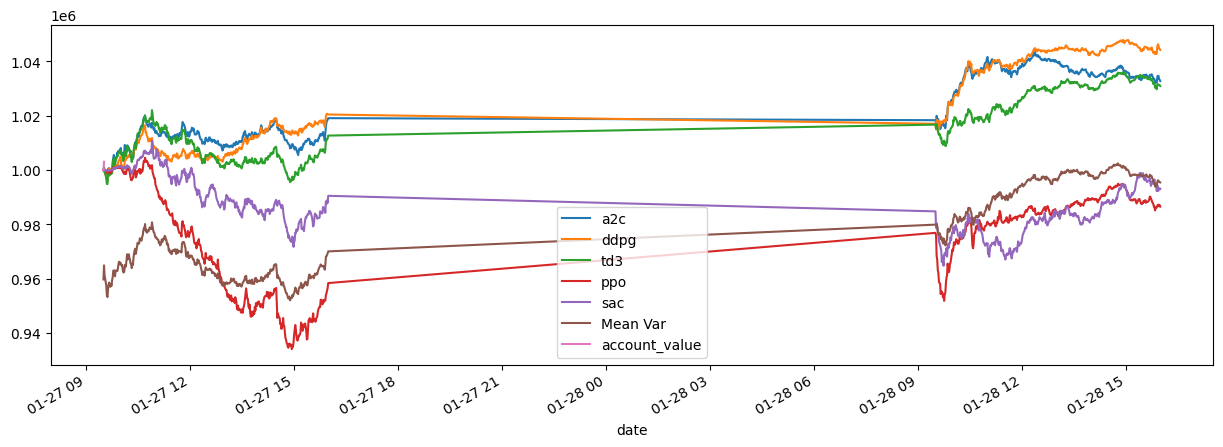

In [44]:
%matplotlib inline
plt.rcParams["figure.figsize"] = (15,5)
plt.figure();
result.plot();